<a href="https://colab.research.google.com/github/sahug/ds-bert/blob/main/BERT%20NLP%20-%20Question%20Answering%20using%20BERT%20and%20Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**BERT Input Format**

To feed a QA task into BERT, we pack both the question and the reference text into the input.

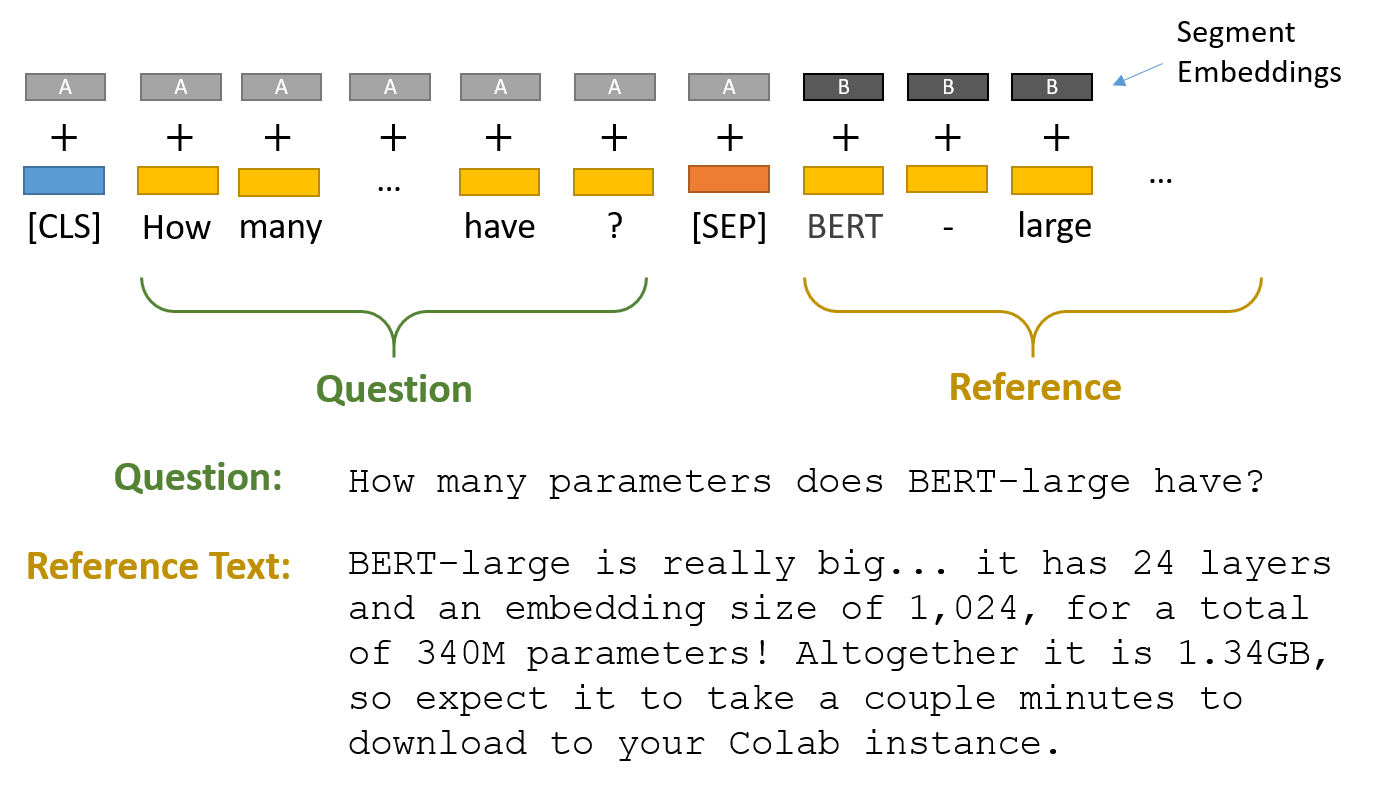

The two pieces of text are separated by the special [SEP] token.

BERT also uses "Segment Embeddings" to differentiate the question from the reference text. These are simply two embeddings (for segments "A" and "B") that BERT learned, and which it adds to the token embeddings before feeding them into the input layer.

Start & End Token Classifiers

BERT needs to highlight a "span" of text containing the answer--this is represented as simply predicting which token marks the start of the answer, and which token marks the end.

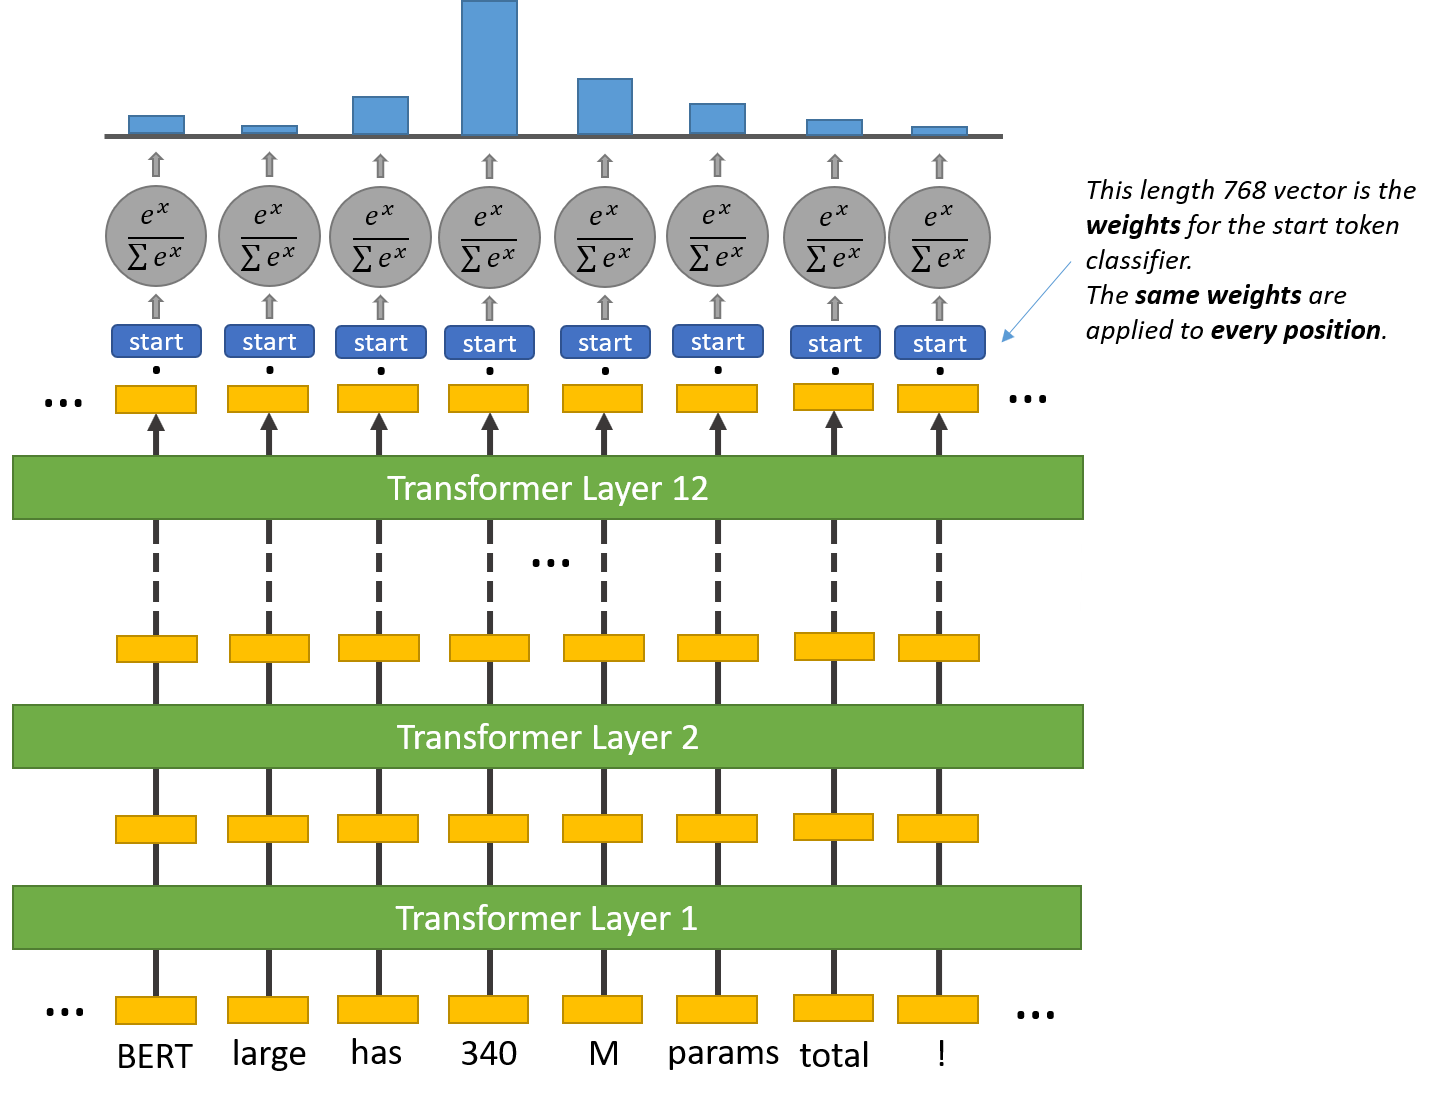

For every token in the text, we feed its final embedding into the start token classifier. The start token classifier only has a single set of weights (represented by the blue "start" rectangle in the above illustration) which it applies to every word.

After taking the dot product between the output embeddings and the 'start' weights, we apply the softmax activation to produce a probability distribution over all of the words. Whichever word has the highest probability of being the start token is the one that we pick.

We repeat this process for the end token--we have a separate weight vector this.

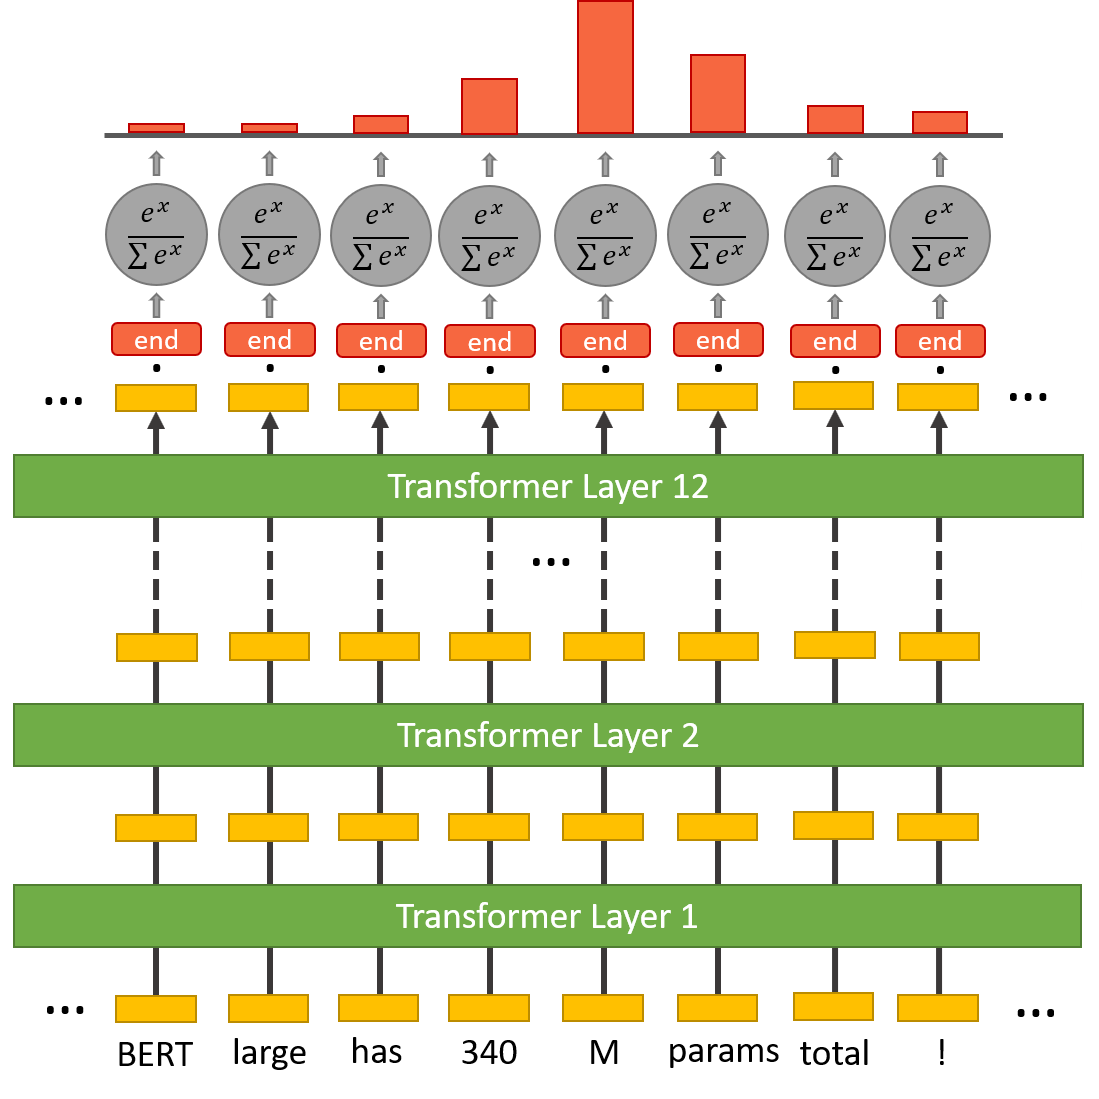

In the example code below, we'll be downloading a model that's already been fine-tuned for question answering, and try it out on our own text.

If you do want to fine-tune on your own dataset, it is possible to fine-tune BERT for question answering yourself. See run_squad.py in the transformers library. However,you may find that the below "fine-tuned-on-squad" model already does a good job, even if your text is from a different domain.

Question answering tasks return an answer given a question. There are two common forms of question answering:

- **Extractive**: Extract the answer from the given context.
- **Abstractive**: Generate an answer from the context that correctly answers the question.

**Load Dataset**

In [1]:
%pip install -qq datasets

     |████████████████████████████████| 346 kB 4.5 MB/s 
     |████████████████████████████████| 86 kB 5.5 MB/s 
     |████████████████████████████████| 1.1 MB 45.7 MB/s 
     |████████████████████████████████| 212 kB 47.9 MB/s 
     |████████████████████████████████| 140 kB 22.1 MB/s 
     |████████████████████████████████| 86 kB 3.3 MB/s 
     |████████████████████████████████| 596 kB 48.4 MB/s 
     |████████████████████████████████| 127 kB 51.4 MB/s 
     |████████████████████████████████| 144 kB 25.8 MB/s 
     |████████████████████████████████| 271 kB 54.2 MB/s 
     |████████████████████████████████| 94 kB 2.0 MB/s 
     |████████████████████████████████| 112 kB 43.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
from datasets import load_dataset
squad = load_dataset("squad")
squad["train"][0]

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

Dataset squad downloaded and prepared to /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

{'answers': {'answer_start': [515], 'text': ['Saint Bernadette Soubirous']},
 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'id': '5733be284776f41900661182',
 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'title': 'University_of_Notre_Dame'}

**Look at Dataset**

In [3]:
from datasets import ClassLabel, Sequence
import random
import pandas as pd
from IPython.display import display, HTML


def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(
        dataset
    ), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset) - 1)
        while pick in picks:
            pick = random.randint(0, len(dataset) - 1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(
                lambda x: [typ.feature.names[i] for i in x]
            )
    display(HTML(df.to_html()))

In [4]:
show_random_elements(squad["train"])

,id,title,context,question,answers
0,572739b6dd62a815002e99bc,Affirmative_action_in_the_United_States,"In the beginning, racial classifications that identified race were inherently suspect and subject to strict scrutiny. These classifications would only be upheld if necessary to promote a compelling governmental interest. Later the U.S. Supreme Court decided that racial classifications that benefited underrepresented minorities were to only be upheld if necessary and promoted a compelling governmental purpose. (See Richmond v. J.A. Croson Co.) There is no clear guidance about when government action is not ""compelling"", and such rulings are rare.",Who later confirmed that racial classifications were only to be upheld if they were necessary?,"{'text': ['U.S. Supreme Court'], 'answer_start': [231]}"
1,572689dbdd62a815002e889b,British_Empire,"The pro-decolonisation Labour government, elected at the 1945 general election and led by Clement Attlee, moved quickly to tackle the most pressing issue facing the empire: that of Indian independence. India's two major political parties—the Indian National Congress and the Muslim League—had been campaigning for independence for decades, but disagreed as to how it should be implemented. Congress favoured a unified secular Indian state, whereas the League, fearing domination by the Hindu majority, desired a separate Islamic state for Muslim-majority regions. Increasing civil unrest and the mutiny of the Royal Indian Navy during 1946 led Attlee to promise independence no later than 1948. When the urgency of the situation and risk of civil war became apparent, the newly appointed (and last) Viceroy, Lord Mountbatten, hastily brought forward the date to 15 August 1947. The borders drawn by the British to broadly partition India into Hindu and Muslim areas left tens of millions as minorities in the newly independent states of India and Pakistan. Millions of Muslims subsequently crossed from India to Pakistan and Hindus vice versa, and violence between the two communities cost hundreds of thousands of lives. Burma, which had been administered as part of the British Raj, and Sri Lanka gained their independence the following year in 1948. India, Pakistan and Sri Lanka became members of the Commonwealth, while Burma chose not to join.",What were India's two largest political parties in the 1940s?,"{'text': ['the Indian National Congress and the Muslim League'], 'answer_start': [238]}"
2,5727beedff5b5019007d941e,Exhibition_game,"Under the 1995–2004 National Hockey League collective bargaining agreement, teams were limited to nine preseason games. From 1975 to 1991, NHL teams sometimes played exhibition games against teams from the Soviet Union in the Super Series, and in 1978, played against World Hockey Association teams also in preseason training. Like the NFL, the NHL sometimes schedules exhibition games for cities without their own NHL teams, often at a club's minor league affiliate (e.g. Carolina Hurricanes games at Time Warner Cable Arena in Charlotte, home of their AHL affiliate; Los Angeles Kings games at Citizens Business Bank Arena in Ontario, California, home of their ECHL affiliate; Montreal Canadiens games at Colisée Pepsi in Quebec City, which has no pro hockey but used to have an NHL team until 1995; Washington Capitals at 1st Mariner Arena in the Baltimore Hockey Classic; various Western Canada teams at Credit Union Centre in Saskatoon, a potential NHL expansion venue). Since the 2000s, some preseason games have been played in Europe against European teams, as part of the NHL Challenge and NHL Premiere series. In addition to the standard preseason, there also exist prospect tournaments such as the Vancouver Canucks' YoungStars tournament and the Detroit Red Wings' training camp, in which NHL teams' younger prospects face off against each other under their parent club's banner.",When did the NFL limit teams to 9 preseason games?,"{'text': ['1995–2004'], 'answer_start': [10]}"
3,57319c9

**Preprocess**

In [5]:
%pip install -qq transformers

     |████████████████████████████████| 4.2 MB 5.2 MB/s 
     |████████████████████████████████| 6.6 MB 38.2 MB/s 


In [6]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [7]:
def preprocess_function(examples):
  
  # Remove leading and trailing spaces
  questions = [q.strip() for q in examples["question"]]

  # Tokenize Inputs
  inputs = tokenizer(
      questions,
      examples["context"],
      max_length=384,
      truncation="only_second",
      return_offsets_mapping=True,
      padding="max_length"
  )

  # Get Offset
  offset_mapping = inputs.pop("offset_mapping")
  answers = examples["answers"]
  start_positions = []
  end_positions = []

  
  for i, offset in enumerate(offset_mapping):
    answer = answers[i]  
    start_char = answer["answer_start"][0]    
    end_char = answer["answer_start"][0] + len(answer["text"][0])
    sequence_ids = inputs.sequence_ids(i)

    # Find start and end of the context
    idx = 0
    while sequence_ids[idx] != 1:
      idx += 1
    context_start = idx
    while sequence_ids[idx] == 1:
      idx += 1
    context_end = idx - 1

    # If the answer is not fully inside the context, label it (0, 0)
    if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
      start_positions.append(0)
      end_positions.append(0)
    else:
      # Otherwise it's the start and end token positions
      idx = context_start
      while idx <= context_end and offset[idx][0] <= start_char:
        idx += 1
      start_positions.append(idx - 1)

      idx = context_end
      while idx >= context_start and offset[idx][1] >= end_char:
        idx -= 1
      end_positions.append(idx + 1)

  inputs["start_positions"] = start_positions
  inputs["end_positions"] = end_positions
  return inputs

**Use Map to apply Function**

In [8]:
tokenized_squad = squad.map(preprocess_function, batched=True, remove_columns=squad["train"].column_names)

  0%|          | 0/88 [00:00<?, ?ba/s]

  0%|          | 0/11 [00:00<?, ?ba/s]

In [9]:
tokenized_squad

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 10570
    })
})

In [10]:
tokenized_squad["train"]["start_positions"][0:10], tokenized_squad["train"]["end_positions"][0:10]

([130, 52, 81, 95, 33, 63, 98, 123, 39, 182],
 [137, 56, 83, 101, 39, 64, 98, 124, 39, 182])

**DefaultDataCollator**

In [11]:
from transformers import DefaultDataCollator
data_collator = DefaultDataCollator(return_tensors="tf")

**Finetune**

In [12]:
import tensorflow as tf

tf_train_set = tokenized_squad["train"].to_tf_dataset(
              columns=["attention_mask", "input_ids", "start_positions", "end_positions"],
              dummy_labels=True,
              shuffle=True,
              batch_size=16,
              collate_fn=data_collator)

tf_validation_set = tokenized_squad["validation"].to_tf_dataset(
              columns=["attention_mask", "input_ids", "start_positions", "end_positions"],
              dummy_labels=True,
              shuffle=False,
              batch_size=16,
              collate_fn=data_collator)

In [13]:
print(tf_train_set, type(tf_train_set))
print(tf_validation_set, type(tf_validation_set))

<PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(16, None), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(16, None), dtype=tf.int64, name=None), 'start_positions': TensorSpec(shape=(16,), dtype=tf.int64, name=None), 'end_positions': TensorSpec(shape=(16,), dtype=tf.int64, name=None)}, TensorSpec(shape=(16,), dtype=tf.float32, name=None))> <class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
<PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, None), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, None), dtype=tf.int64, name=None), 'start_positions': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'end_positions': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.float32, name=None))> <class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>


Here we will use a very small set of data instead of full data.

In [14]:
tf_train_set = tf_train_set.take(5000)
tf_validation_set = tf_validation_set.take(1000)

**Create Optimizer**

In [15]:
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

**DistilBERT**

In [16]:
from transformers import TFAutoModelForQuestionAnswering

model = TFAutoModelForQuestionAnswering.from_pretrained("distilbert-base-uncased", return_dict=True)

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForQuestionAnswering: ['vocab_layer_norm', 'activation_13', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'qa_outputs']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
import tensorflow as tf

model.compile(optimizer=optimizer, loss=loss)

In [ ]:
model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=1)

  25/5000 [..............................] - ETA: 48:54:12 - loss: 0.0000e+00 - end_logits_loss: 0.0000e+00 - start_logits_loss: 0.0000e+00

In [ ]:
import numpy as np
text = "Transformers (formerly known as pytorch-transformers and pytorch-pretrained-bert) provides general-purpose architectures (BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet...) for Natural Language Understanding (NLU) and Natural Language Generation (NLG) with over 32+ pretrained models in 100+ languages and deep interoperability between TensorFlow 2.0 and PyTorch."

questions = [
    "How many pretrained models are available in Transformers?",
    "What does Transformers provide?",
    "Transformers provides interoperability between which frameworks?",
    ]

for question in questions:
    inputs = tokenizer.encode_plus(question, text, add_special_tokens=True, return_tensors="tf")
    input_ids = inputs["input_ids"].numpy()[0]

    text_tokens = tokenizer.convert_ids_to_tokens(input_ids)
    outputs = model(inputs)
    answer_start_scores = outputs.start_logits
    answer_end_scores = outputs.end_logits

    # Get the most likely beginning of answer with the argmax of the score
    answer_start = tf.argmax(answer_start_scores, axis=1).numpy()[0]

    # # Get the most likely end of answer with the argmax of the score
    answer_end = (tf.argmax(answer_end_scores, axis=1) + 1).numpy()[0]

    # print(answer_start_scores, answer_end_scores)
    print(answer_start, answer_end)
    # print(input_ids)
    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))

    print(f"Question: {question}")
    print(f"Answer: {answer}\n")